### Building a Recommender system with Surprise

This try-it focuses on exploring additional algorithms with the `Suprise` library to generate recommendations.  Your goal is to identify the optimal algorithm by minimizing the mean squared error using cross validation. You are also going to select a dataset to use from [grouplens](https://grouplens.org/datasets/movielens/) example datasets.  

To begin, head over to grouplens and examine the different datasets available.  Choose one so that it is easy to create the data as expected in `Surprise` with user, item, and rating information.  Then, compare the performance of at least the `KNNBasic`, `SVD`, `NMF`, `SlopeOne`, and `CoClustering` algorithms to build your recommendations.  For more information on the algorithms see the documentation for the algorithm package [here](https://surprise.readthedocs.io/en/stable/prediction_algorithms_package.html).

Share the results of your investigation and include the results of your cross validation and a basic description of your dataset with your peers.



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from surprise import Dataset, Reader, SVD, NMF, KNNBasic, SlopeOne, CoClustering
from surprise.model_selection import cross_validate
from sklearn.metrics import ConfusionMatrixDisplay

# Introduction to Dataset
This dataset `ml-latest-small` taken from [grouplens](https://grouplens.org/datasets/movielens/) describes 5-star rating and free-text tagging activity from MovieLens, a movie recommendation service. It contains 100836 ratings and 3683 tag applications across 9742 movies. These data were created by 610 users between March 29, 1996 and September 24, 2018. This dataset was generated on September 26, 2018.

Users were selected at random for inclusion. All selected users had rated at least 20 movies. No demographic information is included. Each user is represented by an id, and no other information is provided.

The data are contained in the files links.csv, movies.csv, ratings.csv and tags.csv. More details about the contents and use of all these files follows.

## Ratings Data File Structure (ratings.csv)
All ratings are contained in the file ratings.csv. Each line of this file after the header row represents one rating of one movie by one user, and has the following format:

`userId,movieId,rating,timestamp`
The lines within this file are ordered first by userId, then, within user, by movieId.

Ratings are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars).

Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.

User Ids have been anonymized but they are consistent across files.

Movie Ids are consistent across files and with those used on the MovieLens web site (e.g., id 1 corresponds to the URL https://movielens.org/movies/1). Only movies with at least one rating or tag are included in the dataset.




In [2]:
ratings = pd.read_csv('data/ratings.csv')

In [3]:
movies = pd.read_csv('data/movies.csv')

In [4]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


merge datasets as df to resolve movie titles and genres but it has no affect on the algorithms! Still use `userId, movieId, rating` columns to run models.

In [5]:
df = pd.merge(ratings, movies, how = 'left', on = 'movieId')

In [6]:
# # either this or above dataset
# df = pd.read_csv('data/ratings.csv')

# Exploratory Data Analysis

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
 4   title      100836 non-null  object 
 5   genres     100836 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 5.4+ MB


In [8]:
df.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [9]:
df

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,Split (2017),Drama|Horror|Thriller
100832,610,168248,5.0,1493850091,John Wick: Chapter Two (2017),Action|Crime|Thriller
100833,610,168250,5.0,1494273047,Get Out (2017),Horror
100834,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi


In [10]:
# plt.subplots(figsize=(8,6))
# splot = sns.histplot(data=df, x = 'rating')
# #splot.set_xticklabels(['No Show', 'Donated'])
# plt.xlabel('Rating')
# plt.ylabel('Histogram')
# plt.title('Rating Histogram')
# plt.show()


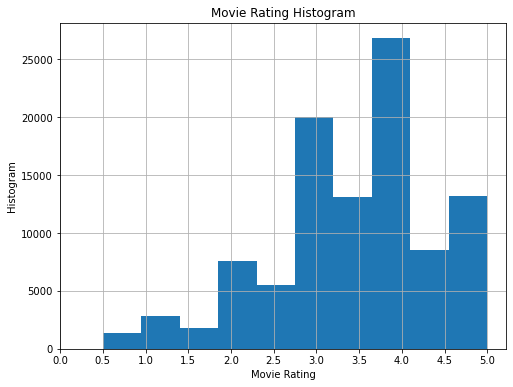

In [11]:
df['rating'].hist(figsize = (8, 6))
plt.xlabel('Movie Rating')
plt.ylabel('Histogram')
plt.title('Movie Rating Histogram')
plt.xticks(np.arange(0, 5.5, .5))
plt.show()

# Models

Prepare datasets for model executions

In [12]:
# set rating scale to 0 - 5
reader = Reader(rating_scale=(0, 5))
# reformat data
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)
# build train and test sets
train = data.build_full_trainset()
test = train.build_testset()

## KNNBasic

In [13]:
%%time
knnb = KNNBasic(random_state = 93)
knnb.fit(train)

# predictions
knnb_preds = knnb.test(test)

# cross validations
knnb_cross = cross_validate(knnb, data, measures=['RMSE'], verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9489  0.9375  0.9510  0.9513  0.9422  0.9462  0.0054  
Fit time          0.08    0.10    0.10    0.11    0.11    0.10    0.01    
Test time         1.06    1.05    1.01    1.10    1.07    1.06    0.03    
CPU times: user 12.6 s, sys: 68.8 ms, total: 12.6 s
Wall time: 12.6 s


In [14]:
knnb_preds[0], knnb_preds[-1]

(Prediction(uid=1, iid=1, r_ui=4.0, est=4.194241094435477, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=610, iid=170875, r_ui=3.0, est=2.7089361394468137, details={'actual_k': 3, 'was_impossible': False}))

## Funk SVD

In [15]:
%%time
fsvd = SVD(random_state = 93)
fsvd.fit(train)

# predictions
fsvd_preds = fsvd.test(test)

# cross validations
fsvd_cross = cross_validate(fsvd, data, measures=['RMSE'], verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8795  0.8750  0.8625  0.8750  0.8743  0.8732  0.0057  
Fit time          3.84    3.80    3.68    3.87    3.59    3.76    0.10    
Test time         0.09    0.22    0.09    0.10    0.10    0.12    0.05    
CPU times: user 24.9 s, sys: 56.4 ms, total: 24.9 s
Wall time: 24.9 s


## NMF

In [16]:
%%time
nmf = NMF(random_state = 93)
nmf.fit(train)

# predictions
nmf_preds = nmf.test(test)

# cross validations
nmf_cross = cross_validate(nmf, data, measures=['RMSE'], verbose=True)

Evaluating RMSE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9340  0.9258  0.9206  0.9142  0.9156  0.9220  0.0073  
Fit time          4.48    4.73    4.62    4.57    4.37    4.55    0.12    
Test time         0.24    0.10    0.09    0.08    0.08    0.12    0.06    
CPU times: user 28.6 s, sys: 59 ms, total: 28.6 s
Wall time: 28.6 s


## Slope One

In [17]:
%%time
sone = SlopeOne()
sone.fit(train)

# predictions
sone_preds = sone.test(test)

# cross validations
sone_cross = cross_validate(sone, data, measures=['RMSE'], verbose=True)

<timed exec>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Evaluating RMSE of algorithm SlopeOne on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9109  0.8945  0.9038  0.8976  0.9056  0.9025  0.0058  
Fit time          4.06    4.12    4.07    4.13    4.04    4.09    0.03    
Test time         5.01    4.67    4.59    4.83    4.37    4.70    0.22    
CPU times: user 1min 10s, sys: 2.8 s, total: 1min 13s
Wall time: 1min 13s


## CoClustering

In [18]:
%%time
cocl = CoClustering(random_state = 93)
cocl.fit(train)

# predictions
cocl_preds = cocl.test(test)

# cross validations
cocl_cross = cross_validate(cocl, data, measures=['RMSE'], verbose=True)

<timed exec>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Evaluating RMSE of algorithm CoClustering on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9430  0.9487  0.9475  0.9366  0.9453  0.9442  0.0043  
Fit time          1.83    1.78    1.78    1.87    1.95    1.84    0.06    
Test time         0.07    0.07    0.07    0.07    0.26    0.11    0.08    
CPU times: user 12.3 s, sys: 113 ms, total: 12.5 s
Wall time: 12.4 s


In [19]:
# cross_val_results
# {'test_rmse': array([0.86831423, 0.88265561, 0.8713308 , 0.88075923, 0.87803021]),
#  'fit_time': (3.7954299449920654,
#   3.855754852294922,
#   3.746534824371338,
#   3.647125005722046,
#   3.7879738807678223),
#  'test_time': (0.19200515747070312,
#   0.10164880752563477,
#   0.17315292358398438,
#   0.10031914710998535,
#   0.10289621353149414)}


In [20]:
cocl_cross['test_rmse'].mean(), sum(cocl_cross['fit_time']), sum(cocl_cross['test_time'])

(0.944206105829395, 9.211119174957275, 0.5369505882263184)

In [21]:
#cocl_preds

# Visualizations

In [22]:
def plot_confusion_matrix(preds):
    # extract y_true and y_pred
    y, y_p = zip(*[(r.r_ui*2, round(r.est*2)) for r in preds])
    
    # plot confusion matrix , display_labels=[0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
    fig, ax = plt.subplots(figsize = (10, 10))
    ConfusionMatrixDisplay.from_predictions(y, y_p, ax = ax)
    plt.title('Confusion Matrix')
    plt.grid(False)
    plt.show()

In [23]:
#y, y_p = zip(*[(r.r_ui, round(r.est*2)/2.0) for r in cocl_preds])
#y_p

#plot_confusion_matrix(cocl_preds)

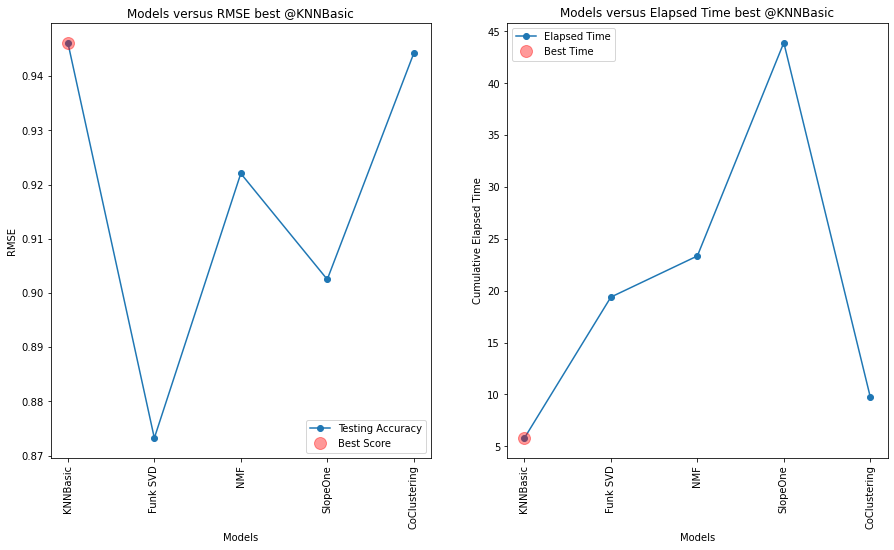

In [24]:
# Time spent
# set metrics!
grid_options=['KNNBasic', 'Funk SVD', 'NMF', 'SlopeOne', 'CoClustering']
test_accs  = [knnb_cross['test_rmse'].mean(), fsvd_cross['test_rmse'].mean(), nmf_cross['test_rmse'].mean(), 
              sone_cross['test_rmse'].mean(), cocl_cross['test_rmse'].mean()]
elapsed_times = [sum(knnb_cross['fit_time']) + sum(knnb_cross['test_time']),
                 sum(fsvd_cross['fit_time']) + sum(fsvd_cross['test_time']),
                 sum(nmf_cross['fit_time'])  + sum(nmf_cross['test_time']),
                 sum(sone_cross['fit_time']) + sum(sone_cross['test_time']),
                 sum(cocl_cross['fit_time']) + sum(cocl_cross['test_time'])]
# plot accuracy and time elapsed
fig, ax = plt.subplots(1, 2, figsize = (15, 8))
ax[0].plot(grid_options, test_accs, '-o', label = 'Testing Accuracy')
ax[0].plot(np.argmax(test_accs), max(test_accs), 'ro', markersize = 12, alpha = 0.4, label = 'Best Score')
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_xlabel('Models')
ax[0].set_ylabel('RMSE')
ax[0].set_title(f'Models versus RMSE best @{grid_options[np.argmax(test_accs)]}')
ax[0].legend()

# time plot
ax[1].plot(grid_options, elapsed_times, '-o', label = 'Elapsed Time')
ax[1].tick_params(axis='x', rotation=90)
ax[1].set_xlabel('Models')
ax[1].set_ylabel('Cumulative Elapsed Time')
ax[1].set_title(f'Models versus Elapsed Time best @{grid_options[np.argmin(elapsed_times)]}')
ax[1].plot(np.argmin(elapsed_times), min(elapsed_times), 'ro', markersize = 12, alpha = 0.4, label = 'Best Time')
ax[1].legend()

In [25]:
pd.DataFrame({'model': grid_options, 
             'RMSE': test_accs,
             'elapsed_time': elapsed_times}
            ).set_index('model')

,RMSE,elapsed_time
model,,
KNNBasic,0.946178,5.792429
Funk SVD,0.873226,19.382019
NMF,0.922045,23.345220
SlopeOne,0.902497,43.908090
CoClustering,0.944206,9.748070


# Fine Tuning Models

In [26]:
%%time
##KNNBasic
sim_params = {'name': 'cosine',
              'user_based': False  # compute  similarities between items
             }
knnb2 = KNNBasic(random_state = 93, k = 50, min_k = 3, sim_options = sim_params)
knnb2.fit(train)

# predictions
knnb_preds2 = knnb2.test(test)

# cross validations
knnb_cross2 = cross_validate(knnb2, data, measures=['RMSE'], verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9635  0.9672  0.9715  0.9708  0.9887  0.9724  0.0087  
Fit time          10.69   10.65   11.41   11.08   11.93   11.15   0.48    
Test time         5.33    5.63    5.54    5.89    5.57    5.59    0.18    
CPU times: user 1min 56s, sys: 7.19 s, total: 2min 4s
Wall time: 2min 3s


In [27]:
%%time
##Funk SVD from 0.02 (overfit 1.0575) to 0.015! Lowering lr_all helped!
fsvd2 = SVD(random_state = 93, n_factors = 10, n_epochs = 100, biased = False, lr_all = 0.015)
fsvd2.fit(train)

# predictions
fsvd_preds2 = fsvd2.test(test)

# cross validations
fsvd_cross2 = cross_validate(fsvd2, data, measures=['RMSE'], verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9900  0.9895  0.9830  0.9687  0.9810  0.9824  0.0077  
Fit time          6.17    6.28    6.23    6.30    6.51    6.30    0.12    
Test time         0.08    0.10    0.08    0.09    0.09    0.09    0.01    
CPU times: user 39.3 s, sys: 73.3 ms, total: 39.3 s
Wall time: 39.3 s


In [28]:
%%time
##NMF from 0.006 (overfit 1.0708) to 0.025! Increasing reg_pu & reg_qi helped!
nmf2 = NMF(random_state = 93, n_factors = 10, n_epochs = 100, biased = False, reg_pu = 0.025, reg_qi = 0.025)
nmf2.fit(train)

# predictions
nmf_preds2 = nmf2.test(test)

# cross validations
nmf_cross2 = cross_validate(nmf2, data, measures=['RMSE'], verbose=True)

Evaluating RMSE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9803  0.9758  0.9825  0.9757  0.9869  0.9803  0.0042  
Fit time          7.71    7.60    7.67    7.81    7.81    7.72    0.08    
Test time         0.08    0.08    0.08    0.08    0.10    0.08    0.01    
CPU times: user 48.2 s, sys: 73.8 ms, total: 48.3 s
Wall time: 48.3 s


In [29]:
%%time
##SlopeOne
# takes no parameter
sone2 = SlopeOne()
sone2.fit(train)

# predictions
sone_preds2 = sone2.test(test)

# cross validations
sone_cross2 = cross_validate(sone2, data, measures=['RMSE'], verbose=True)

<timed exec>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Evaluating RMSE of algorithm SlopeOne on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9010  0.8938  0.9013  0.9135  0.8969  0.9013  0.0067  
Fit time          4.15    4.06    4.04    4.21    4.10    4.11    0.06    
Test time         4.94    4.80    4.82    4.61    4.66    4.76    0.12    
CPU times: user 1min 10s, sys: 2.83 s, total: 1min 13s
Wall time: 1min 13s


In [30]:
%%time
##CoClustering
# n_cltr_u (int) – Number of user clusters. Default is 3.
# n_cltr_i (int) – Number of item clusters. Default is 3.
# n_epochs (int) – Number of iteration of the optimization loop. Default is 20.

cocl2 = CoClustering(random_state = 93, n_cltr_u = 12, n_cltr_i = 12, n_epochs = 100)
cocl2.fit(train)

# predictions
cocl_preds2 = cocl2.test(test)

# cross validations
cocl_cross2 = cross_validate(cocl2, data, measures=['RMSE'], verbose=True)

<timed exec>:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Evaluating RMSE of algorithm CoClustering on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9793  0.9674  0.9826  0.9786  0.9796  0.9775  0.0052  
Fit time          14.81   14.67   14.45   14.68   14.68   14.66   0.12    
Test time         0.08    0.07    0.07    0.07    0.39    0.14    0.13    
CPU times: user 1min 28s, sys: 679 ms, total: 1min 28s
Wall time: 1min 28s


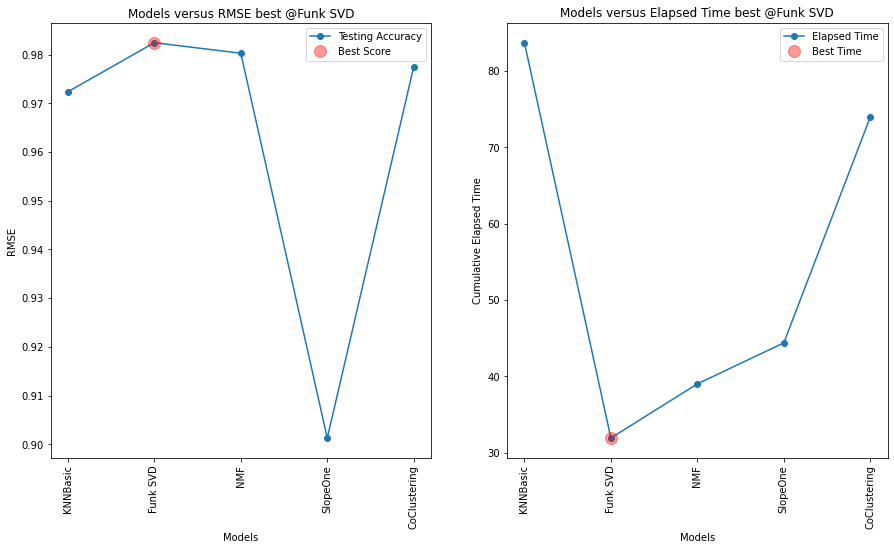

In [31]:
# Time spent
# set metrics!
grid_options2=['KNNBasic', 'Funk SVD', 'NMF', 'SlopeOne', 'CoClustering']
test_accs2  = [knnb_cross2['test_rmse'].mean(), fsvd_cross2['test_rmse'].mean(), nmf_cross2['test_rmse'].mean(), 
              sone_cross2['test_rmse'].mean(), cocl_cross2['test_rmse'].mean()]
elapsed_times2 = [sum(knnb_cross2['fit_time']) + sum(knnb_cross2['test_time']),
                 sum(fsvd_cross2['fit_time']) + sum(fsvd_cross2['test_time']),
                 sum(nmf_cross2['fit_time'])  + sum(nmf_cross2['test_time']),
                 sum(sone_cross2['fit_time']) + sum(sone_cross2['test_time']),
                 sum(cocl_cross2['fit_time']) + sum(cocl_cross2['test_time'])]
# plot accuracy and time elapsed
fig, ax = plt.subplots(1, 2, figsize = (15, 8))
ax[0].plot(grid_options2, test_accs2, '-o', label = 'Testing Accuracy')
ax[0].plot(np.argmax(test_accs2), max(test_accs2), 'ro', markersize = 12, alpha = 0.4, label = 'Best Score')
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_xlabel('Models')
ax[0].set_ylabel('RMSE')
ax[0].set_title(f'Models versus RMSE best @{grid_options2[np.argmax(test_accs2)]}')
ax[0].legend()

# time plot
ax[1].plot(grid_options2, elapsed_times2, '-o', label = 'Elapsed Time')
ax[1].tick_params(axis='x', rotation=90)
ax[1].set_xlabel('Models')
ax[1].set_ylabel('Cumulative Elapsed Time')
ax[1].set_title(f'Models versus Elapsed Time best @{grid_options2[np.argmin(elapsed_times2)]}')
ax[1].plot(np.argmin(elapsed_times2), min(elapsed_times2), 'ro', markersize = 12, alpha = 0.4, label = 'Best Time')
ax[1].legend()

In [32]:
pd.DataFrame({'model': grid_options2, 
             'RMSE': test_accs2,
             'elapsed_time': elapsed_times2}
            ).set_index('model')

,RMSE,elapsed_time
model,,
KNNBasic,0.972350,83.731241
Funk SVD,0.982425,31.918107
NMF,0.980259,39.013430
SlopeOne,0.901315,44.391405
CoClustering,0.977487,73.981756


# Top N

In [33]:
from collections import defaultdict
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.

    Check out for more SURPRISE examples:
        https://surprise.readthedocs.io/en/stable/FAQ.html
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [34]:
#defaultdict(list)

In [35]:
# All users
top_n = get_top_n(cocl_preds2, 5)

In [36]:
# user 17
[(movies.loc[movies['movieId'] == iid, 'title'], rating) for iid, rating in top_n[17]]

[(2568    Double Indemnity (1944)
  Name: title, dtype: object,
  4.891546601066998),
 (2623    Outlaw Josey Wales, The (1976)
  Name: title, dtype: object,
  4.878474705642161),
 (474    Blade Runner (1982)
  Name: title, dtype: object,
  4.757109212490918),
 (2145    American Beauty (1999)
  Name: title, dtype: object,
  4.720739826026655),
 (1494    Seven Samurai (Shichinin no samurai) (1954)
  Name: title, dtype: object,
  4.697919150086604)]

### Top 5 Results per User 17

KNN
```
[(911     Star Wars: Episode VI - Return of the Jedi (1983),  4.380525373689884),
 (1503    Saving Private Ryan (1998),  4.379897343225128),
 (97      Braveheart (1995),  4.368996844186546),
 (2743    For a Few Dollars More (Per qualche dollaro in...,  4.3500311577305055),
 (4800    Lord of the Rings: The Return of the King, The...,  4.349948122173956)]
```
  
SVD
```
[(1939    Matrix, The (1999),  4.762507409802968),
 (659     Godfather, The (1972),  4.613647063141319),
 (3984    Spirited Away (Sen to Chihiro no kamikakushi) ...,  4.6121289193965485),
 (2226    Fight Club (1999),  4.59929205144252),
 (510     Silence of the Lambs, The (1991),  4.592112817644183)]
```
  
NMF
```
[(5695    Old Boy (2003),  4.664905657896616),
 (659     Godfather, The (1972),  4.595745010502069),
 (4769    Nausicaä of the Valley of the Wind (Kaze no ta...,  4.572468721803215),
 (224     Star Wars: Episode IV - A New Hope (1977),  4.499789437591513),
 (602     Dr. Strangelove or: How I Learned to Stop Worr...,  4.474597592215093)]
```
  
SlopeOne
```
[(659     Godfather, The (1972),  4.715753793474932),
 (277     Shawshank Redemption, The (1994),  4.663368415073634),
 (257     Pulp Fiction (1994),  4.65934590226499),
 (602     Dr. Strangelove or: How I Learned to Stop Worr...,  4.635543583952147),
 (898     Star Wars: Episode V - The Empire Strikes Back...,  4.602479767733954)]
```

CoClustering
```
[(2568    Double Indemnity (1944),  4.891546601066998),
 (2623    Outlaw Josey Wales, The (1976),  4.878474705642161),
 (474     Blade Runner (1982),  4.757109212490918),
 (2145    American Beauty (1999),  4.720739826026655),
 (1494    Seven Samurai (Shichinin no samurai) (1954),  4.697919150086604)]
```